In [1]:
from dataclasses import dataclass
from typing import Optional
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.datasets import make_moons
from tqdm import tqdm, trange

In [2]:
random_seed = 123
torch_gen = torch.manual_seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model

In [3]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.
    
    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor
    loss: Optional[torch.Tensor] = None
    loss_recon: Optional[torch.Tensor] = None
    loss_kl: Optional[torch.Tensor] = None


class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int | list[int]): Dimensionality of the hidden layers.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim: int, hidden_dim: int | list[int], latent_dim: int):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        encoder_layers_list = []
        if type(hidden_dim) != list:
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim))
            encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim, 2 * latent_dim))
        else:
            self.hidden_dim = hidden_dim.copy()
            encoder_layers_list.append(nn.Linear(input_dim, hidden_dim[0]))
            encoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim[1:])):
                encoder_layers_list.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
                encoder_layers_list.append(nn.LeakyReLU())
            encoder_layers_list.append(nn.Linear(hidden_dim[-1], 2 * latent_dim))
        
        self.encoder = nn.Sequential(*encoder_layers_list)

        decoder_layers_list = []
        if type(hidden_dim) != list:
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim))
            decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim, input_dim))
        else:
            hidden_dim_decoder = hidden_dim[::-1]
            decoder_layers_list.append(nn.Linear(latent_dim, hidden_dim_decoder[0]))
            decoder_layers_list.append(nn.LeakyReLU())
            for i in range(len(hidden_dim_decoder[1:])):
                decoder_layers_list.append(nn.Linear(hidden_dim_decoder[i], hidden_dim_decoder[i+1]))
                decoder_layers_list.append(nn.LeakyReLU())
            decoder_layers_list.append(nn.Linear(hidden_dim_decoder[-1], input_dim))

        self.decoder = nn.Sequential(*decoder_layers_list)

        print(f"Encoder: {encoder_layers_list}")
        print(f"Decoder: {decoder_layers_list}")

    def encode(self, x: torch.Tensor, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        params = self.encoder(x)
        means = params[:, :self.latent_dim]
        covs = torch.diag_embed(torch.exp(params[:, self.latent_dim:]) + eps)
        return torch.distributions.MultivariateNormal(means, covariance_matrix=covs)

    def decode(self, z: torch.Tensor):
        """
        Decodes the data from the latent space into the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.Tensor: The decoded x from the latent sample.
        """
        return self.decoder(z)
    
    def forward(self, x: torch.Tensor, kl_weight: float = 1.0, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        z_dist = self.encode(x)
        z = z_dist.rsample()
        recon_x = self.decode(z)
        
        if not compute_loss:
            return VAEOutput(
                z_dist=z_dist,
                z_sample=z,
                x_recon=recon_x,
            )
        
        # Compute loss terms
        loss_recon = nn.functional.mse_loss(recon_x, x, reduction='sum')
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(z_dist, std_normal).mean()
        
        loss = loss_recon + kl_weight * loss_kl
        
        return VAEOutput(
            z_dist=z_dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )

# Data

In [4]:
def gen_train_test_split(train_size: int, test_size: int, noise: float = 0.15):
    X_train, y_train = make_moons(n_samples=train_size, noise=noise, random_state=random_seed)
    X_test, y_test = make_moons(n_samples=test_size, noise=(noise * 1.5), random_state=random_seed)
    return (X_train, y_train), (X_test, y_test)


class MoonsDataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self._X = X
        self._y = y
        self.X = torch.from_numpy(self._X).float()
        self.y = torch.from_numpy(self._y.reshape(-1, 1)).float()
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def __len__(self):
        return self.X.shape[0]

In [5]:
train_split, test_split = gen_train_test_split(1500, 500)

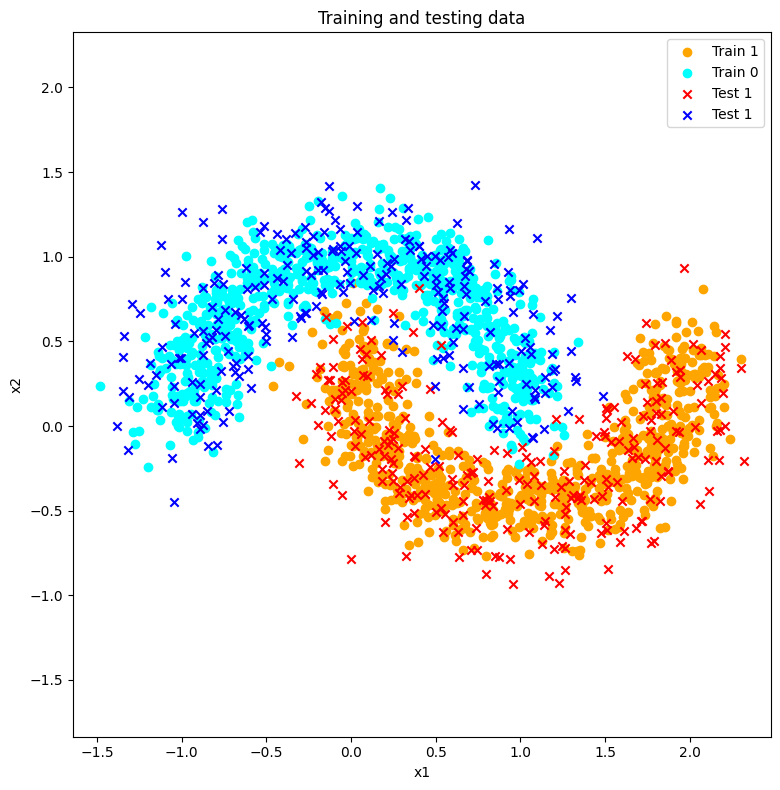

In [6]:
fig = plt.figure(figsize=(8, 8))
# Train data
train_cls_mask = train_split[1].astype(bool)
plt.scatter(
    train_split[0][train_cls_mask, 0],
    train_split[0][train_cls_mask, 1],
    color='orange', label='Train 1',
)
plt.scatter(
    train_split[0][~train_cls_mask, 0],
    train_split[0][~train_cls_mask, 1],
    color='cyan', label='Train 0',
)
# Test data
test_cls_mask = test_split[1].astype(bool)
plt.scatter(
    test_split[0][test_cls_mask, 0],
    test_split[0][test_cls_mask, 1],
    color='red', marker='x', label='Test 1',
)
plt.scatter(
    test_split[0][~test_cls_mask, 0],
    test_split[0][~test_cls_mask, 1],
    color='blue', marker='x', label='Test 1',
)

plt.title('Training and testing data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.axis('equal')
plt.tight_layout()
plt.show()

# Training

## Training functions

In [7]:
def train(
    model: VAE,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    kl_weight: float,
):
    """
    Trains the model on the given data.
    
    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        optimizer: The optimizer.
    """
    model.train()
    loss_total = 0.0
    loss_recon = 0.0
    loss_kl = 0.0
    for data, _ in dataloader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data, kl_weight, compute_loss=True)
        loss = output.loss
        loss.backward()
        optimizer.step()
        loss_total += loss.item()
        loss_recon += output.loss_recon.item()
        loss_kl += output.loss_kl.item()
    n_batchs = len(dataloader)
    loss_total /= n_batchs
    loss_recon /= n_batchs
    loss_kl /= n_batchs
    return loss_total, loss_recon, loss_kl


def test(model: VAE, dataloader: DataLoader):
    """
    Tests the model on the given data.
    
    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
    """
    model.eval()
    loss_total = 0.0
    loss_recon = 0.0
    loss_kl = 0.0
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            output = model(data, compute_loss=True)
        loss_total += output.loss.item()
        loss_recon += output.loss_recon.item()
        loss_kl += output.loss_kl.item()
    n_batchs = len(dataloader)
    loss_total /= n_batchs
    loss_recon /= n_batchs
    loss_kl /= n_batchs
    return loss_total, loss_recon, loss_kl

## Training run

In [8]:
learning_rate = 1e-4
batch_size = 100
num_epochs = 300
input_dim = 2
latent_dim = 2
hidden_dim = [128, 64]
kl_weight = 1.0

train_loader = DataLoader(
    MoonsDataset(*train_split),
    batch_size=batch_size,
    shuffle=True,
    generator=torch_gen,
)
test_loader = DataLoader(
    MoonsDataset(*test_split),
    batch_size=batch_size,
    shuffle=False,
)

print(f"Using device: {device}")

Using device: cuda


In [9]:
print("Training Variational Autoencoder...")
model_VAE = VAE(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim,
).to(device)

print(model_VAE)

optimizer = torch.optim.AdamW(model_VAE.parameters(), lr=learning_rate)

train_loss_history = []
test_loss_history = []
for epoch in trange(1, num_epochs + 1, desc='Training', unit='epoch'):
    train_loss = train(model_VAE, train_loader, optimizer, kl_weight)
    test_loss = test(model_VAE, test_loader)
    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)

Training Variational Autoencoder...
Encoder: [Linear(in_features=2, out_features=128, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=128, out_features=64, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=64, out_features=4, bias=True)]
Decoder: [Linear(in_features=2, out_features=64, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=64, out_features=128, bias=True), LeakyReLU(negative_slope=0.01), Linear(in_features=128, out_features=2, bias=True)]
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): LeakyReLU(negati

Training: 100%|██████████| 300/300 [01:20<00:00,  3.71epoch/s]


## Plot functions

In [10]:
def plot_curves(train_loss_history, test_loss_history):
    losses_label = ('Total', 'Reconstruction', 'KL')
    _, axs = plt.subplots(1, 3, figsize=(10, 4))
    for i, loss_label in enumerate(losses_label):
        ax = axs[i]
        ax.plot(
            range(1, len(train_loss_history) + 1),
            [l[i] for l in train_loss_history],
            label='Training',
        )
        ax.plot(
            range(1, len(test_loss_history) + 1),
            [l[i] for l in test_loss_history],
            label='Testing',
        )
        ax.set_xlabel('Epochs')
        ax.set_ylabel(f'{loss_label} loss')
        ax.set_title(f'{loss_label} loss evolution')
        ax.grid()
        ax.legend()
    plt.tight_layout()
    plt.show()


def plot_latent_space(model: VAE):
    _ = plt.figure(figsize=(8, 8))
    model.eval()
    for i, (split, colors, marker, dataloader) in enumerate((
        ('Train', ('cyan', 'orange'), 'o', train_loader),
        ('Test', ('blue', 'red'), 'x', test_loader)
    )):
        z_all = []
        y_all = []
        with torch.no_grad():
            for data, target in tqdm(dataloader, desc='Encoding', unit='batch'):
                z = model.encode(data.to(device))
                z = z.mean
                z_all.append(z.detach().cpu().numpy())
                y_all.append(target.numpy())
        z_all = np.concatenate(z_all, axis=0)
        y_all = np.concatenate(y_all, axis=0)
        cls_mask = y_all.astype(bool).flatten()
        plt.scatter(z_all[cls_mask, 0], z_all[cls_mask, 1], color=colors[1], marker=marker, label=f'{split} 1')
        plt.scatter(z_all[~cls_mask, 0], z_all[~cls_mask, 1], color=colors[0], marker=marker,  label=f'{split} 0')
    plt.title('Projections (Latent Space)')
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.legend()
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


def plot_random_samples(model: VAE, num_samples: int = 200):
    model.eval()
    std_normal = torch.distributions.MultivariateNormal(
        torch.zeros(model.latent_dim, device=device),
        covariance_matrix=torch.eye(model.latent_dim, device=device),
    )
    samples = model.decode(std_normal.sample((num_samples,))).detach().cpu().numpy()
    _ = plt.figure(figsize=(8, 8))
    plt.scatter(samples[:, 0], samples[:, 1])
    plt.title('Generated Samples (Input Space)')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

## Results

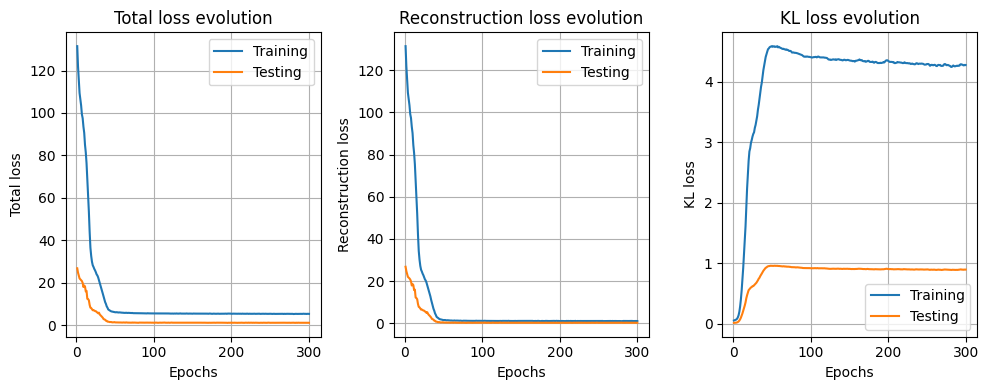

In [11]:
plot_curves(train_loss_history, test_loss_history)

Encoding: 100%|██████████| 5/5 [00:00<00:00, 181.92batch/s]


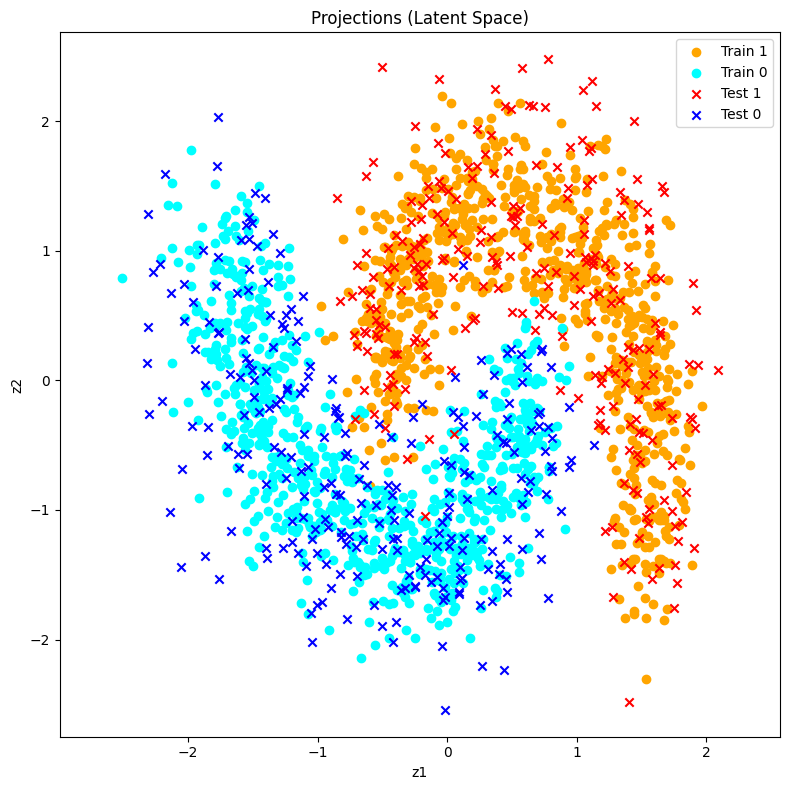

In [12]:
plot_latent_space(model_VAE)

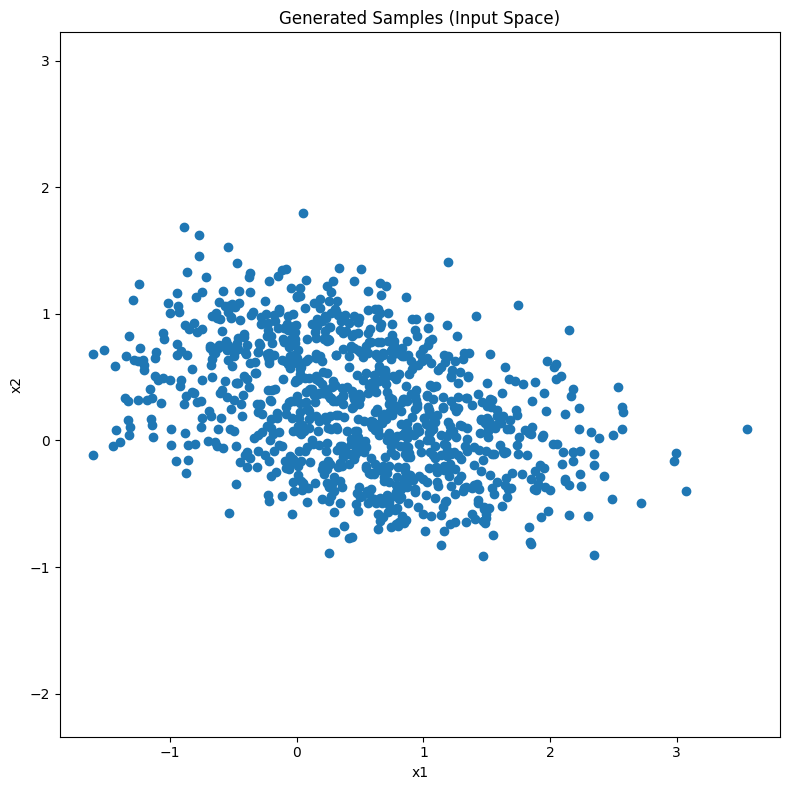

In [13]:
plot_random_samples(model_VAE, 1000)